# $\mathrm{OT}_\varepsilon$-minimization with moment constraints using generalized iterative scaling (GIS)

Solve
$$
\min_{\nu}\mathrm{OT}_\varepsilon(\mu, \nu) \quad \text{subject to} \quad A\nu = b,
$$
for some affine space given by $A\in \mathbb{R}^{m\times M}, b\in\mathbb{R}^{m}$, where $\nu\in \mathbb{R}^M$ runs over the probability measures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, vonmises
from scipy.spatial.distance import squareform, pdist, cdist
from scipy.optimize import linprog

In [2]:
np.set_printoptions(suppress=True, precision=5)

## Generate data

In [3]:
M = 100
x = np.linspace(0.0, 1.0, M)

In [4]:
# mu
mean = 0.4
std = 0.1
mu = norm(loc=mean, scale=std).pdf(x)
mu /= mu.sum()

In [5]:
eval_shift = 0.1
scaling = 1.5

# shifted and scaled gaussian
shifted_scaled = norm(loc=mean + eval_shift, scale=std*scaling).pdf(x)
shifted_scaled /= shifted_scaled.sum()

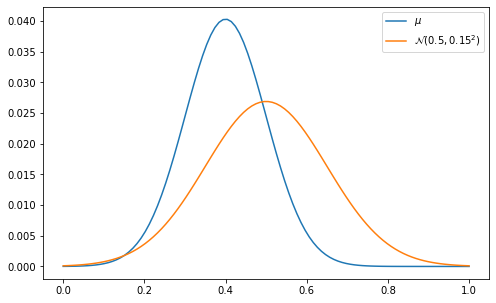

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(x, mu, label=r'$\mu$')
plt.plot(x, shifted_scaled, label=r'$\mathcal{N}(0.5, 0.15^2)$')
plt.legend()
plt.show()

In [7]:
# ot cost
c = squareform(pdist(x[:, None], metric='sqeuclidean'))

## First experiment:
If $X\sim\mu, Y\sim \nu$, then we set affine constraints
$$
\mathbb{E}[Y] 
= \mathbb{E}[X] + 0.1
= 0.5 \quad \text{and} \quad 
\mathrm{Var}[Y] 
= 1.5^2\mathrm{Var}[X] 
= 0.15^2.
$$

## Solve using GIS

In [8]:
A = np.array([
    x, # first moment
    x*x # second moment
])
b = np.array([
    (mu*x).sum() + eval_shift,
    ((mu*x).sum() + eval_shift)**2 + scaling**2*((mu*x*x).sum()-(mu*x).sum()**2)
])

Prepare $A, b$ for GIS (column stochasticity)

In [9]:
def constr_prep(A, b):
    # step 1: make A, b >= 0
    minimum = min(A.min(), b.min())
    A = A - minimum
    b = b - minimum

    # step 2: make A, b <= 1
    maximum = max(A.sum(axis=0).max(), b.sum())
    A /= maximum
    b /= maximum

    # step 3: make cols sum to one
    A = np.concatenate([A, 1-A.sum(axis=0)[None, :]], axis=0)
    b = np.concatenate([b, [1-b.sum()]])
    
    return A, b

In [10]:
A, b = constr_prep(A, b)

Perform Sinkhorn-like algorithm

In [11]:
eps = 0.01
K = np.exp(-c/eps)

In [12]:
def gis_sinkhorn(K, A, b, n_iter_max=int(1e5), err_thres=1e-4):
    
    it = 0
    err = np.inf
    u = np.ones(M)
    u_prev = np.ones(M)
    v = np.ones(M)
    
    while it < n_iter_max and err > err_thres:
        u_prev = u.copy()
        
        # update for mu constraint
        u = mu / K.dot(v)
        
        # gis update for nu constraint
        v_update = np.exp(A.T.dot(np.log(b / A.dot(v * K.T.dot(u)))))
        v *= v_update

        # convergence management
        nu_marg = v*K.T.dot(u)
        err = max(max(abs(np.log(u/u_prev))), max(abs(np.log(v_update))))
        it += 1
        
    print(f"Converged after {it} iterations.")
    pi = u[:, None]*K*v[None, :]
    
    return pi

In [13]:
pi = gis_sinkhorn(K, A, b)

Converged after 6664 iterations.


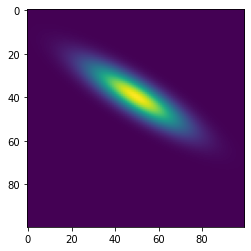

In [14]:
plt.imshow(pi)

## Solve using LP

In [15]:
A = np.array([
    x, # first moment
    x*x # second moment
])
b = np.array([
    (mu*x).sum() + eval_shift,
    ((mu*x).sum() + eval_shift)**2 + scaling**2*((mu*x*x).sum()-(mu*x).sum()**2)
])

In [16]:
mu_constraints = np.stack([np.tile(x[:, None], reps=(1, M)).flatten() for x in np.eye(M)])
nu_constraints = np.stack([np.tile(constr[None, :], reps=(M, 1)).flatten() for constr in A])

In [17]:
A_flat = np.concatenate([mu_constraints, nu_constraints], axis=0)
b_flat = np.concatenate([mu, b])

In [18]:
res = linprog(c.flatten(), A_eq=A_flat, b_eq=b_flat)

In [19]:
res

     con: array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])
     fun: 0.012508031532713142
 message: 'Optimization terminated successfully.'
     nit: 29
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0.00001, 0.     , 0.     , ..., 0.     , 0.     , 0.     ])

In [20]:
pi_lp = res.x.reshape((M, M))

pi_lp.sum()

1.0000000311426251

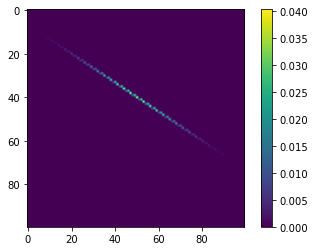

In [21]:
plt.imshow(pi_lp)
plt.colorbar()

## Comparison

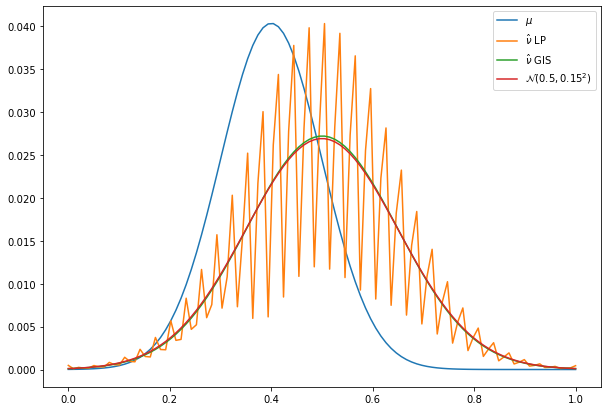

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(x, mu, label=r'$\mu$')
plt.plot(x, pi_lp.sum(axis=0), label=r'$\hat\nu$ LP')
plt.plot(x, pi.sum(axis=0), label=r'$\hat\nu$ GIS')
plt.plot(x, shifted_scaled, label=r'$\mathcal{N}(0.5, 0.15^2)$')
plt.legend()
plt.show()

## Second experiment:
On the torus $\mathbb{T}=\mathrm{e}^{\mathrm{i}[0, 2\pi]}$ with, such that if $X\sim \mu,Y\sim \nu$, then $X, Y\in \mathbb{T}$ and the expectation values $\mathbb{E}[X], \mathbb{E}[Y]\in \mathbb{C}$ are complex numbers. Let $z:= \mathbb{E}[X]$, then we set the constraint
$$
E[Y] = \vert z\vert \mathrm{e}^{\mathrm{i}(\arg(z)+\pi/2)},
$$
i.e., we rotate the mean by $\frac{\pi}{2}$.

## Generate data

In [23]:
# torus
M = 100
angles = np.linspace(-np.pi, np.pi*(1-2/M), M)
x = np.exp(1j*angles)

In [24]:
# von mises distribution
exp_angle = -1.0
std = 0.1*np.pi*2
mu = vonmises(loc=exp_angle, kappa=1/std**2).pdf(angles)
mu /= mu.sum()

In [25]:
eval_angle_shift = np.pi/2

# shifted von mises distribution
shifted = vonmises(loc=exp_angle + eval_angle_shift, kappa=1/std**2).pdf(angles)
shifted /= shifted.sum()

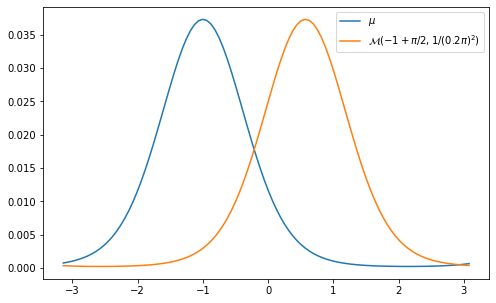

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(angles, mu, label=r'$\mu$')
ax.plot(angles, shifted, label=r'$\mathcal{M}(-1+\pi/2, 1/(0.2 \pi)^2)$')
plt.legend()
plt.show()

In [27]:
c = np.stack([
    squareform(pdist(angles[:, None], metric='sqeuclidean')),
    cdist(angles[:, None], angles[:, None] + 2*np.pi, metric='sqeuclidean'),
    cdist(angles[:, None], angles[:, None] - 2*np.pi, metric='sqeuclidean'),    
]).min(axis=0) / (2*np.pi)**2

In [28]:
eps = 0.01
K = np.exp(-c/eps)

In [29]:
z = (x*mu).sum()
zprime = abs(z)*np.exp(1j*(np.angle(z) + np.pi/2))

In [30]:
A = np.array([
    x.real,
    x.imag,
])
b = np.array([
    zprime.real,
    zprime.imag
])

In [31]:
A, b = constr_prep(A, b)

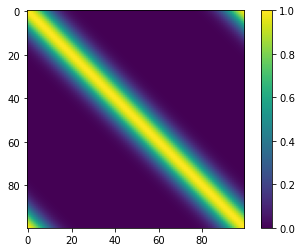

In [32]:
plt.imshow(K)
plt.colorbar()
plt.show()

In [33]:
eps = 0.01
K = np.exp(-c/eps)

In [34]:
pi = gis_sinkhorn(K, A, b)

Converged after 364 iterations.


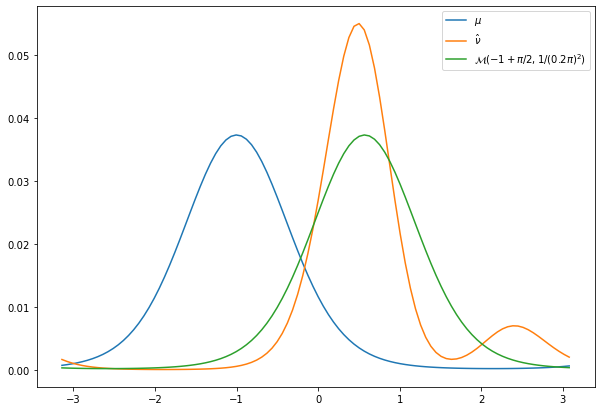

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(angles, mu, label=r'$\mu$')
plt.plot(angles, pi.sum(axis=0), label=r'$\hat\nu$')
plt.plot(angles, shifted, label=r'$\mathcal{M}(-1+\pi/2, 1/(0.2 \pi)^2)$')
plt.legend()
plt.show()

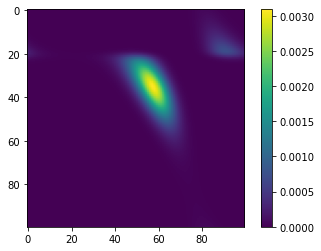

In [36]:
fig, ax = plt.subplots()
plt.imshow(pi)
plt.colorbar()
plt.show()